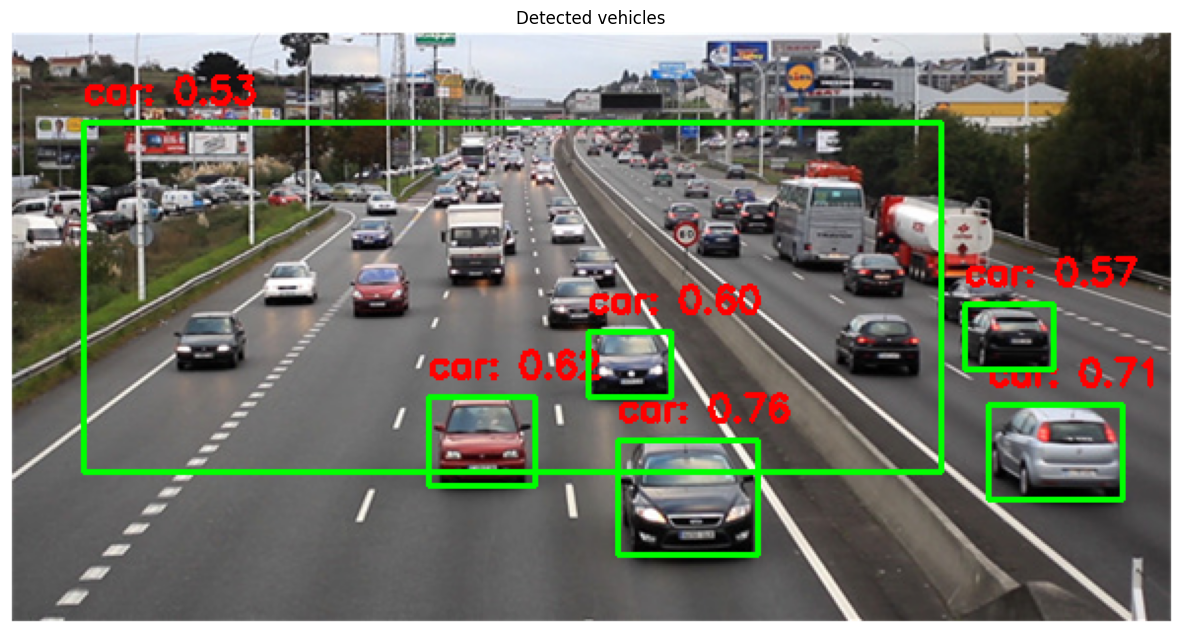

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import json

model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
class_names = ["__background__"]
with urllib.request.urlopen(url) as f:
    class_names += [line.decode('utf-8').strip() for line in f]

# classes: 3=car, 6=bus, 8=truck
TARGET_CLASS_NAMES = ['car', 'bus', 'truck']

image_path = "/content/image.jpg"
image_bgr = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width, _ = image_rgb.shape

resized_image = cv2.resize(image_rgb, (320, 320))
input_tensor = tf.convert_to_tensor(resized_image, dtype=tf.uint8)
input_tensor = tf.expand_dims(input_tensor, 0)

outputs = model(input_tensor)

detection_scores = outputs['detection_scores'][0].numpy()
detection_classes = outputs['detection_classes'][0].numpy().astype(np.int32)
detection_boxes = outputs['detection_boxes'][0].numpy()

for i in range(len(detection_scores)):
    score = detection_scores[i]
    class_id = detection_classes[i]
    class_name = class_names[class_id] if class_id < len(class_names) else f"ID {class_id}"

    if score > 0.5 and class_name in TARGET_CLASS_NAMES:
        ymin, xmin, ymax, xmax = detection_boxes[i]
        left = int(xmin * width)
        right = int(xmax * width)
        top = int(ymin * height)
        bottom = int(ymax * height)
        cv2.rectangle(image_rgb, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(image_rgb, f"{class_name}: {score:.2f}", (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(15, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Detected vehicles")
plt.show()

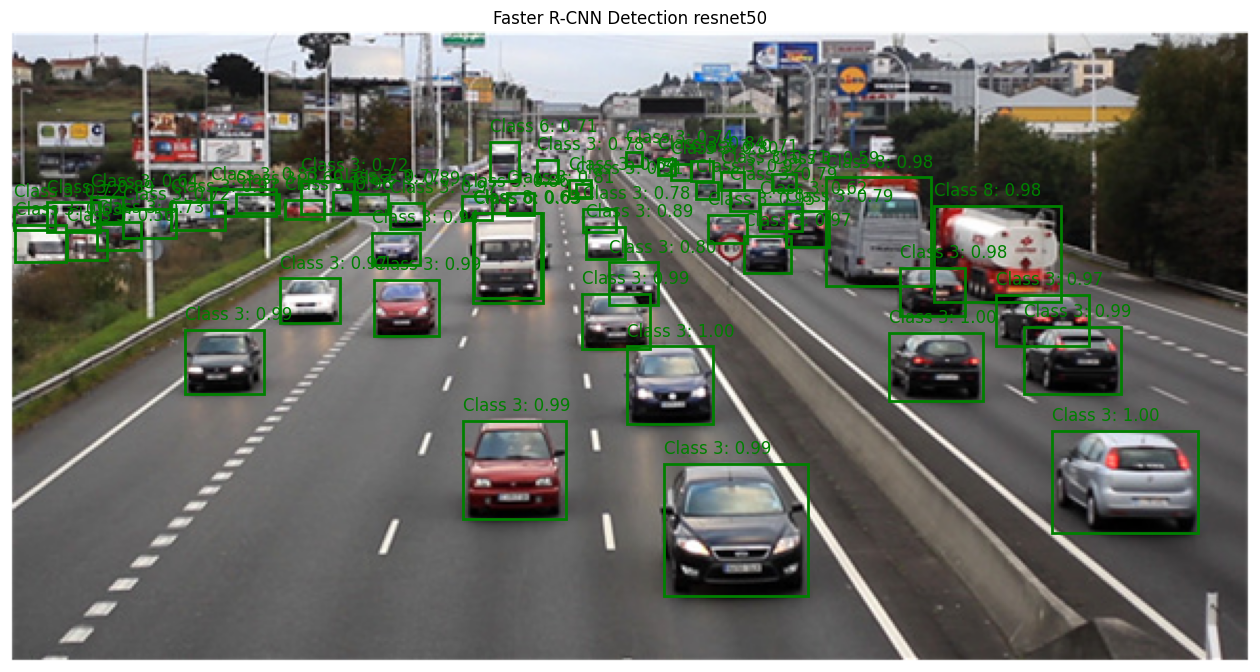

In [16]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# classes: 3=car, 6=bus, 8=truck
TARGET_CLASS_IDS = [3, 6, 8]

image_path = "/content/image.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    outputs = model(image_tensor)

fig, ax = plt.subplots(1, figsize=(16, 9))
ax.imshow(image)

for box, label, score in zip(outputs[0]['boxes'], outputs[0]['labels'], outputs[0]['scores']):
    class_id = label.item()
    if score > 0.5 and class_id in TARGET_CLASS_IDS:
        xmin, ymin, xmax, ymax = box
        label_text = f"Class {class_id}: {score:.2f}"
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, label_text, color='green',
                fontsize=12)

plt.axis('off')
plt.title("Faster R-CNN Detection resnet50")
plt.show()


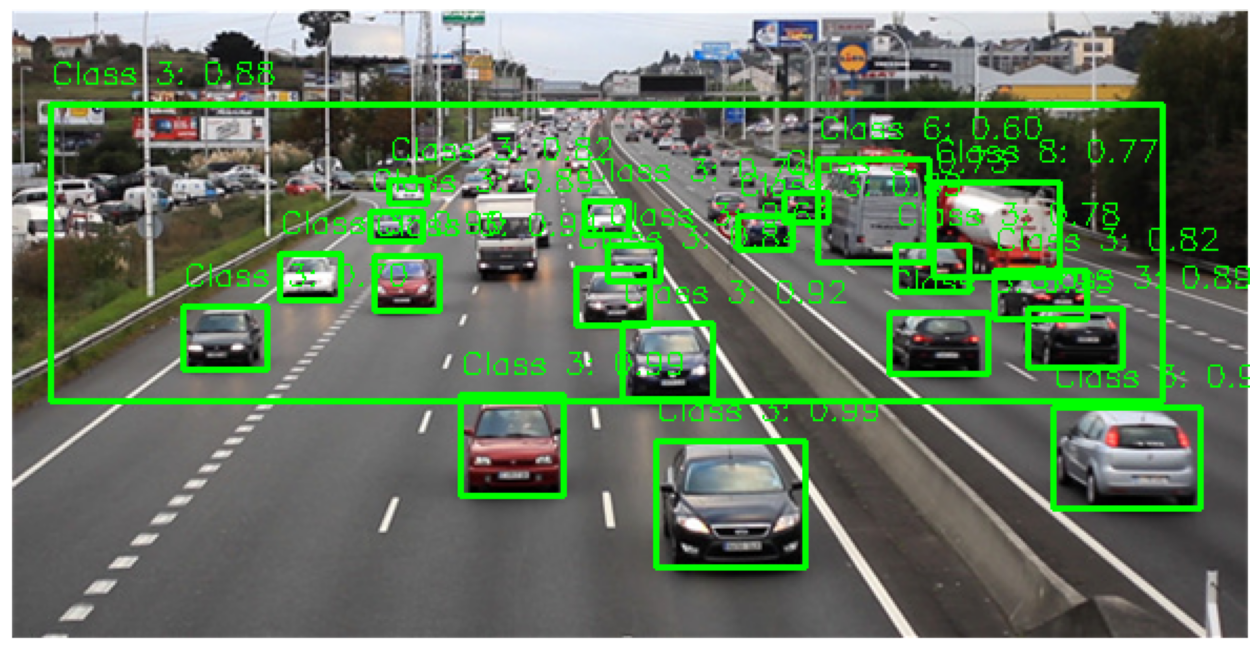

In [17]:
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1")

image_path = "/content/image.jpg"
image_np = np.array(Image.open(image_path))

input_tensor = tf.convert_to_tensor(image_np)[tf.newaxis, ...]

detections = model(input_tensor)

boxes = detections['detection_boxes'][0].numpy()
scores = detections['detection_scores'][0].numpy()
classes = detections['detection_classes'][0].numpy().astype(np.int32)

# classes: 3=car, 6=bus, 8=truck
car_classes = [3, 6, 8]

image_with_boxes = image_np.copy()
h, w, _ = image_with_boxes.shape

for i in range(len(scores)):
    if scores[i] > 0.6 and classes[i] in car_classes:
        ymin, xmin, ymax, xmax = boxes[i]
        start_point = (int(xmin * w), int(ymin * h))
        end_point = (int(xmax * w), int(ymax * h))
        cv2.rectangle(image_with_boxes, start_point, end_point, (0, 255, 0), 2)
        label = f"Class {classes[i]}: {scores[i]:.2f}"
        cv2.putText(image_with_boxes, label, (start_point[0], start_point[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(16, 10))
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()
